# **Fatal Car Crashes in MN**

Cole Evanson


## Project Scaffold
|Element|My Plan|
|-|-|
|Hypothesis|MN has a systematic difference in fatal crashes involving interstate junctions than other states.|
|Outcome/Metric/Test Stat|Mean fatal junction related interstate crashes in MN per year - non-MN|
|Unit of Analysis|1 state - year: Miles Driven, Fatal Crashes|
|Data Source(s)|https://cdan.dot.gov/query, https://catalog.data.gov/dataset/vehicle-miles-of-travel-by-functional-system-and-state-1980-2023-vm-2, https://www.census.gov/programs-surveys/popest/technical-documentation/research/evaluation-estimates/2020-evaluation-estimates/2010s-state-total.html|
|Why this data works|The data provides yearly counts of fatal crashes, classified as Interstate Junction or not, based on the reports from the accidents. The other data also includes the total miles driven by drivers in each state, also classified by roadway class. |
|Uncertainty Metric|Fatal Crashes per Total Miles Driven |
|Null Hypothesis|Null: MN has no difference in number of fatal interstate junction motor vehicle crashes. |

## **Data loading and Exploration**

In [59]:
# Imports and Configuratioon
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

crash_filepath = "CrashReport_filled(in).csv"
miles_filepath = "Vehicle_Miles_of_Travel_by_State_1980_to_2023.csv"
census_2010s_filepath = "population_2010_2020.csv"
census_2020s_filepath = "population_2020_2024.csv"

In [60]:
# Read in data
crash = pd.read_csv(crash_filepath)
miles = pd.read_csv(miles_filepath)
census_2010s = pd.read_csv(census_2010s_filepath)
census_2020s = pd.read_csv(census_2020s_filepath)


### CDAN Data on # of Fatal Crashes

In [61]:
# Exploration
print(f"Preview:\n{crash.sample(5)}\n")
print(f"Shape:\n{crash.shape}\n")
print(f"Info:")
print(crash.info())
print(f"\nDescribe:\n{crash.describe()}")

Preview:
            State      Interstate      Junction  2013  2014  2015  2016  2017  \
718  South Dakota      Interstate  Non-Junction    14     8    20     8    11   
508        Nevada           Total       Unknown     0     0     0     0     0   
176       Georgia      Interstate       Unknown     0     0     0     0     0   
57       Arkansas      Interstate       Unknown     0     0     0     0     0   
60       Arkansas  Non-Interstate  Non-Junction   294   281   323   337   329   

     2018  2019  2020  2021  2022  2023  Total  
718     9    12    15    16    16    21    150  
508     1     0     0     0     0     0      1  
176     0     0     3     0     0     0      3  
57      0     0     1     0     0     0      1  
60    319   316   408   395   349   334   3685  

Shape:
(908, 15)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 


### DOT Data on # of Miles Driven

In [62]:
# Exploration
print(f"Preview:\n{miles.sample(5)}\n")
print(f"Shape:\n{miles.shape}\n")
print(f"Info:")
print(miles.info())
print(f"\nDescribe:\n{miles.describe()}")

Preview:
       Year        State   Area                          FClass  \
12175  2006      Alabama  Urban  Other Freeways and Expressways   
6661   2014     Delaware  Urban                 Major Collector   
22850  1989  Connecticut  Rural                  Minor Arterial   
22170  1990       Alaska  Urban                      Interstate   
23741  1988       Nevada  Rural                           Local   

                    VMT  
12175  7.1400000000e+08  
6661   7.7500032440e+08  
22850  1.1480000000e+09  
22170  4.1800000000e+08  
23741  3.0000000000e+08  

Shape:
(29016, 5)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29016 entries, 0 to 29015
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    29016 non-null  int64  
 1   State   29016 non-null  object 
 2   Area    29016 non-null  object 
 3   FClass  29016 non-null  object 
 4   VMT     29016 non-null  float64
dtypes: float64(1), int64(1), object(3)

## **Join the Crash and Mileage Data at a State|Year Level**
#### Crash Data is Interstate + Junction, and Mileage Data is Interstate (Junction designation not available)

In [63]:
# Create a dataframe of just state level
crash_clean = crash.query("Interstate == 'Interstate' and Junction == 'Junction'").reset_index(drop=True)
#print(f"Rows before dropping total row {crash_clean.shape}")

# Identify year columns (4-digit column names)
year_cols = [col for col in crash_clean.columns 
             if str(col).isdigit() and len(str(col)) == 4]

# Everything else stays as identifiers
id_cols = [col for col in crash_clean.columns if col not in year_cols]

# Melt it
crash_clean = crash_clean.melt(
    id_vars=id_cols,
    value_vars=year_cols,
    var_name="Year",
    value_name="Value"
)

# ensure year is numeric and get rid of that total
crash_clean["Year"] = crash_clean["Year"].astype(int)
crash_clean["Value"] = pd.to_numeric(crash_clean["Value"], errors="coerce")
crash_clean = crash_clean.drop(columns = ["Total"])

crash_clean = crash_clean[crash_clean['State']!="Total"].copy()

# Clean and join with mileage driven on the interstate in each state
miles['Year'] = miles['Year'].astype(int)
miles_clean = miles[(miles['Year']>2012) & (miles['FClass']=="Interstate")].copy()
miles_clean = miles_clean.groupby(['Year','State','FClass'])['VMT'].sum().reset_index()

# Get the number of Junction Interstate Fatal Crashes per Interstate Total Miles Driven per Year
df_all = pd.merge(crash_clean, miles_clean, on=["State", "Year"], how="inner")
df_all['crash_per_mile'] = df_all['Value']/df_all['VMT']

# string cleaning
df_all['State'] = df_all["State"].str.strip().str.lower()
df_all['Year'] = df_all['Year'].astype(int)

#crash_clean = df_all.copy()
interstate_clean = df_all.copy()

#print("Missing Values:")
#print(interstate_clean.isna().sum().sort_values(ascending=False))
print(f"Shape: \n{interstate_clean.shape}")
print("\nSampler:")
print(interstate_clean.sample(5))
print("\nDescription:")
interstate_clean.describe()



Shape: 
(517, 8)

Sampler:
             State  Interstate  Junction  Year  Value      FClass  \
489  massachusetts  Interstate  Junction  2023      0  Interstate   
417        vermont  Interstate  Junction  2021      0  Interstate   
478        florida  Interstate  Junction  2023      3  Interstate   
319   rhode island  Interstate  Junction  2019      0  Interstate   
193       colorado  Interstate  Junction  2017      0  Interstate   

                  VMT    crash_per_mile  
489  1.6816910820e+10  0.0000000000e+00  
417  1.4911361300e+09  0.0000000000e+00  
478  4.6042047820e+10  6.5157831635e-11  
319  2.1621060492e+09  0.0000000000e+00  
193  1.4357086879e+10  0.0000000000e+00  

Description:


,Year,Value,VMT,crash_per_mile
count,517.0000000000,517.0000000000,5.1700000000e+02,5.1700000000e+02
mean,2018.0000000000,1.2978723404,1.6156684827e+10,8.8816594855e-11
std,3.1653403995,3.5677625443,1.6552399286e+10,2.3552926427e-10
min,2013.0000000000,0.0000000000,1.1907669300e+09,0.0000000000e+00
25%,2015.0000000000,0.0000000000,4.7961067200e+09,0.0000000000e+00
50%,2018.0000000000,0.0000000000,1.2395016998e+10,0.0000000000e+00
75%,2021.0000000000,1.0000000000,2.1491571488e+10,9.1581139844e-11
max,2023.0000000000,41.0000000000,9.2131421407e+10,2.5227758885e-09


### **Visualizations of Crash/Mileage Interstate Junction Data**

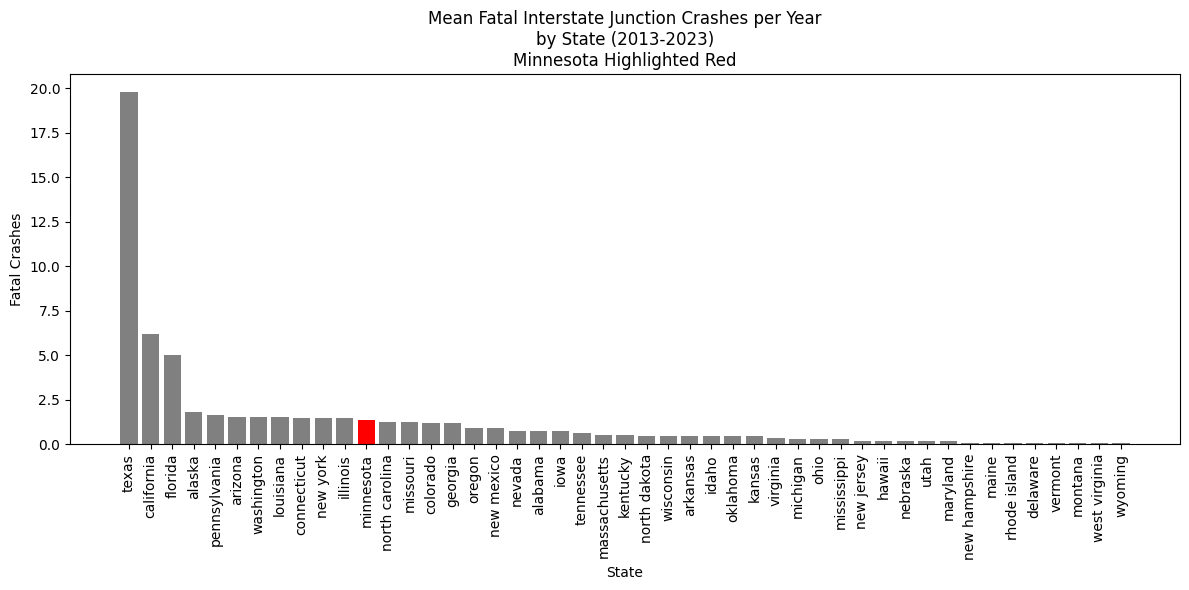

In [64]:
# Mean fatal interstate junction crashes per year 2013-2023
crashes_per_year = interstate_clean.groupby("State")["Value"].mean().reset_index().sort_values('Value', ascending=False).reset_index(drop=True)

colors = ['red' if state == 'minnesota' else 'gray' for state in crashes_per_year['State']]

plt.figure(figsize=(12,6))
plt.bar(crashes_per_year['State'], crashes_per_year['Value'], color=colors)
plt.xticks(rotation=90)
plt.ylabel("Fatal Crashes")
plt.xlabel("State")
plt.title("Mean Fatal Interstate Junction Crashes per Year\nby State (2013-2023)\nMinnesota Highlighted Red")
plt.tight_layout()
plt.show()

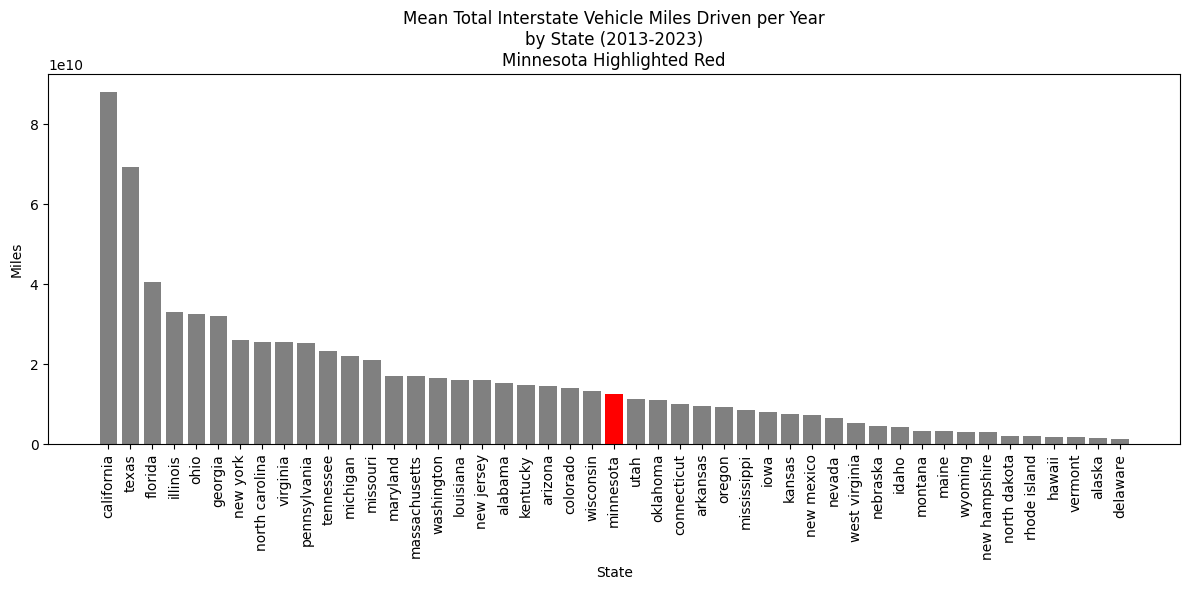

In [65]:
# Mean Insterstate Miles Driven per Year by State

crashes_per_year = interstate_clean.groupby("State")["VMT"].mean().reset_index().sort_values('VMT', ascending=False).reset_index(drop=True)

colors = ['red' if state == 'minnesota' else 'gray' for state in crashes_per_year['State']]

plt.figure(figsize=(12,6))
plt.bar(crashes_per_year['State'], crashes_per_year['VMT'], color=colors)
plt.xticks(rotation=90)
plt.ylabel("Miles")
plt.xlabel("State")
plt.title("Mean Total Interstate Vehicle Miles Driven per Year\nby State (2013-2023)\nMinnesota Highlighted Red")
plt.tight_layout()
plt.show()

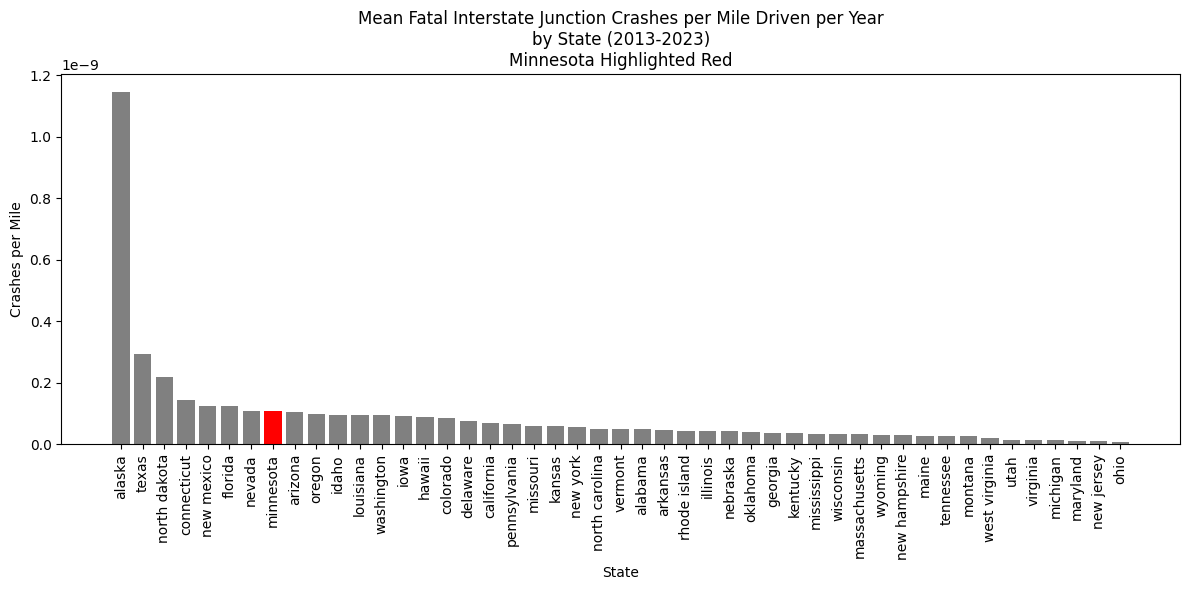

In [66]:
# Mean fatal interstate junction crashes per mile driven per year 2013-2023
crashes_per_mile_per_year = interstate_clean.groupby("State")["crash_per_mile"].mean().reset_index().sort_values('crash_per_mile', ascending=False).reset_index(drop=True)

colors = ['red' if state == 'minnesota' else 'gray' for state in crashes_per_mile_per_year['State']]

plt.figure(figsize=(12,6))
plt.bar(crashes_per_mile_per_year['State'], crashes_per_mile_per_year['crash_per_mile'], color=colors)
plt.xticks(rotation=90)
plt.ylabel("Crashes per Mile")
plt.xlabel("State")
plt.title("Mean Fatal Interstate Junction Crashes per Mile Driven per Year\nby State (2013-2023)\nMinnesota Highlighted Red")
plt.tight_layout()
plt.show()

## **Join the Crash and Mileage Data at a State|Year Level**
#### Crash and Mileage Data is Totals

In [67]:
# To be Added

### **Visualizations of Crash/Mileage Totals**

In [68]:
# To be Added

## **Census Data Cleaning**

In [69]:
# Identify year columns (4-digit column names)
year_cols = [col for col in census_2010s.columns 
             if str(col).isdigit() and len(str(col)) == 4]

# Everything else stays as identifiers
id_cols = [col for col in census_2010s.columns if col not in year_cols]

# Melt it
census_2010 = census_2010s.melt(
    id_vars=id_cols,
    value_vars=year_cols,
    var_name="Year",
    value_name="Population"
)

# Identify year columns (4-digit column names)
year_cols = [col for col in census_2020s.columns 
             if str(col).isdigit() and len(str(col)) == 4]

# Everything else stays as identifiers
id_cols = [col for col in census_2020s.columns if col not in year_cols]

# Melt it
census_2020 = census_2020s.melt(
    id_vars=id_cols,
    value_vars=year_cols,
    var_name="Year",
    value_name="Population"
)

census = pd.concat([census_2010, census_2020], axis=0, ignore_index=True)

census['Population'] = census['Population'].str.replace(',', '').astype(float)
census['Geographic Area'] = census["Geographic Area"].str.strip().str.lower().str.replace('.','')
census['Year'] = census['Year'].astype(int)
census = census.rename(columns={'Geographic Area':'State'})

### **Join Population with VMT**

In [70]:
# Population and VMT by State and Year
# Clean and join with mileage driven on the interstate in each state
miles['Year'] = miles['Year'].astype(int)
miles_sum = miles.groupby(["State","Year"])['VMT'].sum().reset_index()
miles_sum = miles_sum[miles_sum['Year']>2012].copy()
miles_sum['State'] = miles_sum['State'].str.strip().str.lower()

census_VMT = pd.merge(census, miles_sum, on=["State", "Year"], how="inner")

### **Visualzation and Regression on Population and VMT**

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


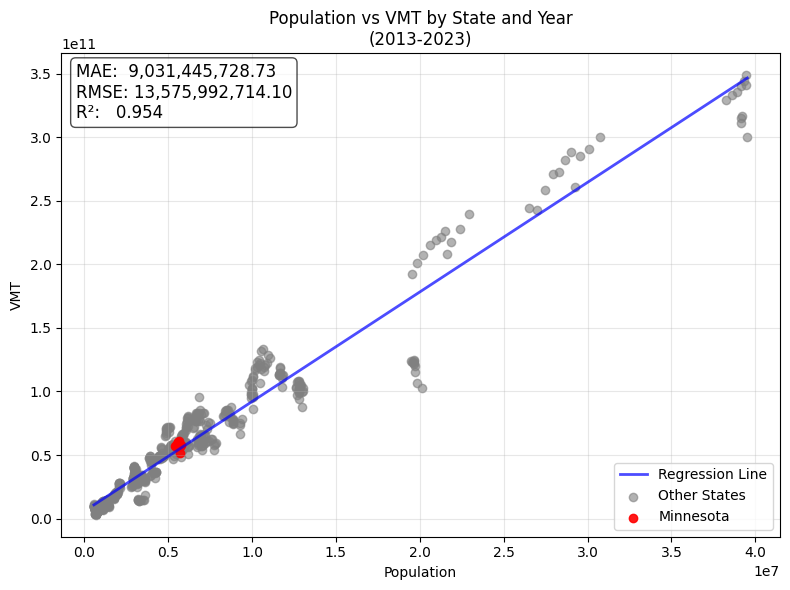

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Regression
X = census_VMT[['Population']]   # must be 2D
y = census_VMT['VMT']

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

#print("Intercept:", model.intercept_)
#print("Slope:", model.coef_[0])
#print("MAE:", mae)
#print("RMSE:", rmse)
#print("R²:", r2)



# Scatter Plot and Line

# Line points
x_line = np.linspace(census_VMT['Population'].min(), census_VMT['Population'].max(), 200).reshape(-1, 1)
y_line = model.predict(x_line)

mn_mask = census_VMT['State'] == "minnesota"
other_mask = census_VMT['State'] != "minnesota"

plt.figure(figsize=(8,6))

plt.plot(x_line, y_line, color="blue", linewidth=2, label="Regression Line", alpha =0.7)

# non MN
plt.scatter(
    census_VMT.loc[other_mask, 'Population'],
    census_VMT.loc[other_mask, 'VMT'],
    alpha=0.6,
    label="Other States",
    color="grey"
)

# MN
plt.scatter(
    census_VMT.loc[mn_mask, 'Population'],
    census_VMT.loc[mn_mask, 'VMT'],
    alpha=0.9,
    label="Minnesota",
    color="red"
)

plt.xlabel("Population")
plt.ylabel("VMT")
plt.title("Population vs VMT by State and Year\n(2013-2023)")
plt.legend()
plt.grid(True, alpha=0.3)

# add in the metrics onto the chart
metrics_text = (
    f"MAE:  {mae:,.2f}\n"
    f"RMSE: {rmse:,.2f}\n"
    f"R²:   {r2:.3f}"
)

plt.text(
    0.02, 0.98, metrics_text,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='left',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
)

plt.tight_layout()
plt.show()


## **Permutation Test on Raw # of Interstate Junction Crashes MN vs USA**

In [72]:
interstate_clean['MN'] = np.where(interstate_clean['State'] == 'minnesota', 'MN', 'Not MN')
observed_diff = interstate_clean.groupby('MN')['Value'].mean().loc['MN'] - interstate_clean.groupby('MN')['Value'].mean().loc['Not MN']
observed_diff, interstate_clean.groupby('MN')['Value'].mean().loc['MN'], interstate_clean.groupby('MN')['Value'].mean().loc['Not MN']

(0.0671936758893279, 1.3636363636363635, 1.2964426877470356)

In [73]:
crash_copy = interstate_clean.copy()
crash_copy = crash_copy.reset_index(drop=True)

results =[]
n = 10_000

for i in range(n):
    crash_copy['MN'] = crash_copy['MN'].sample(frac=1,replace=False).values
    means = crash_copy.groupby('MN')['Value'].mean()
    diff = means.loc["MN"] - means.loc["Not MN"]
    results.append(diff)

pval = 0

for i in range(0,n):
    if np.abs(results[i]) > np.abs(observed_diff):
        pval += 1
    else:
        pval += 0

pval = pval/n

print(f"The p-value is {pval}")


The p-value is 0.9296


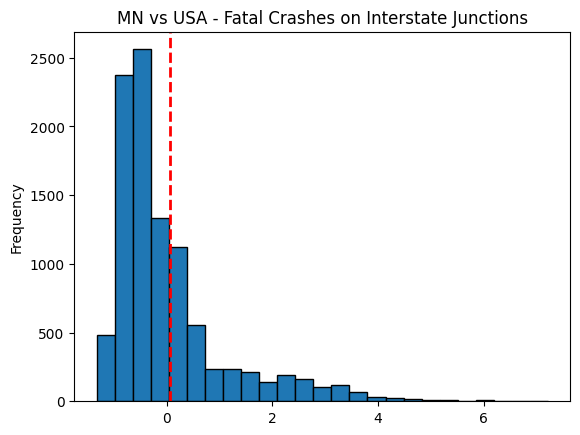

In [74]:
plt.figure()
plt.hist(results, bins = 25, edgecolor ='black')
plt.title("MN vs USA - Fatal Crashes on Interstate Junctions")
plt.ylabel("Frequency")
plt.axvline(x=observed_diff, color='red', linestyle='--', linewidth=2)
plt.show()

The p-value is 0.7708


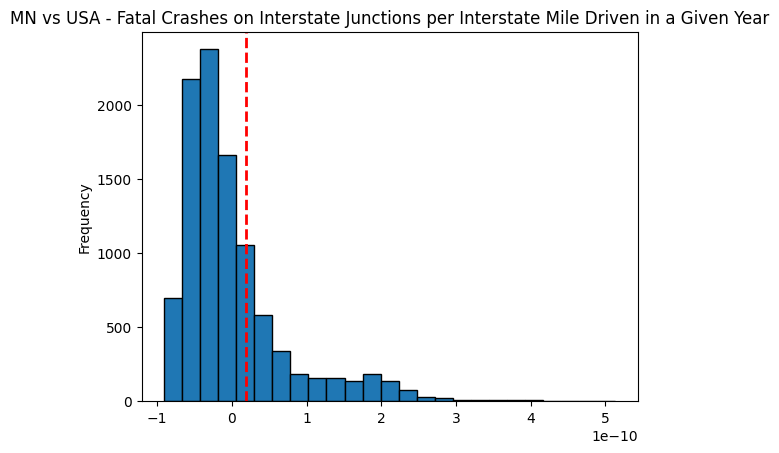

In [75]:
observed_diff = interstate_clean.groupby('MN')['crash_per_mile'].mean().loc['MN'] - interstate_clean.groupby('MN')['crash_per_mile'].mean().loc['Not MN']

crash_copy = interstate_clean.copy()
crash_copy = crash_copy.reset_index(drop=True)

results =[]
n = 10_000

for i in range(n):
    crash_copy['MN'] = crash_copy['MN'].sample(frac=1,replace=False).values
    means = crash_copy.groupby('MN')['crash_per_mile'].mean()
    diff = means.loc["MN"] - means.loc["Not MN"]
    results.append(diff)

pval = 0

for i in range(0,n):
    if np.abs(results[i]) > np.abs(observed_diff):
        pval += 1
    else:
        pval += 0

pval = pval/n

print(f"The p-value is {pval}")

plt.figure()
plt.hist(results, bins = 25, edgecolor ='black')
plt.title("MN vs USA - Fatal Crashes on Interstate Junctions per Interstate Mile Driven in a Given Year")
plt.ylabel("Frequency")
plt.axvline(x=observed_diff, color='red', linestyle='--', linewidth=2)
plt.show()


### *Results for Fatal Crashes on Interstate Junctions:* **MN is not different than the rest of the country in this area.**

## **Let's also look at *total* fatal crashes per mile driven, per year, by state**

In [76]:
fatal_total = crash.query("Interstate == 'Total' and Junction == 'Total' and State != 'Total'").reset_index(drop=True)

# Identify year columns (4-digit column names)
year_cols = [col for col in fatal_total.columns 
             if str(col).isdigit() and len(str(col)) == 4]

# Everything else stays as identifiers
id_cols = [col for col in fatal_total.columns if col not in year_cols]

# Melt it
fatal_total = fatal_total.melt(
    id_vars=id_cols,
    value_vars=year_cols,
    var_name="Year",
    value_name="Value"
)

# ensure year is numeric and get rid of that total
fatal_total["Year"] = fatal_total["Year"].astype(int)
fatal_total["Value"] = pd.to_numeric(fatal_total["Value"], errors="coerce")
fatal_total = fatal_total.drop(columns = ["Total"])

# Clean and join with mileage driven on the interstate in each state
miles['Year'] = miles['Year'].astype(int)
miles_sum = miles.groupby(["State","Year"])['VMT'].sum().reset_index()
miles_sum = miles_sum[miles_sum['Year']>2012].copy()

# Get the number of Junction Interstate Fatal Crashes per Interstate Total Miles Driven per Year
df_all = pd.merge(fatal_total, miles_sum, on=["State", "Year"], how="inner")
df_all['crash_per_mile'] = df_all['Value']/df_all['VMT']

df_all['State'] = df_all['State'].str.strip().str.lower()

total_fatal_crash_per_mile = df_all.copy()
total_fatal_crash_per_mile


,State,Interstate,Junction,Year,Value,VMT,crash_per_mile
0,alabama,Total,Total,2013,767,6.5046483928e+10,0.0000000118
1,alaska,Total,Total,2013,49,4.8484547718e+09,0.0000000101
2,arizona,Total,Total,2013,782,6.0586171362e+10,0.0000000129
3,arkansas,Total,Total,2013,460,3.3493274314e+10,0.0000000137
4,california,Total,Total,2013,2860,3.2953413303e+11,0.0000000087
...,...,...,...,...,...,...,...
556,virginia,Total,Total,2023,855,8.7730191840e+10,0.0000000097
557,washington,Total,Total,2023,733,5.9803783960e+10,0.0000000123
558,west virginia,Total,Total,2023,233,1.5962390250e+10,0.0000000146
559,wisconsin,Total,Total,2023,530,6.7248397730e+10,0.0000000079


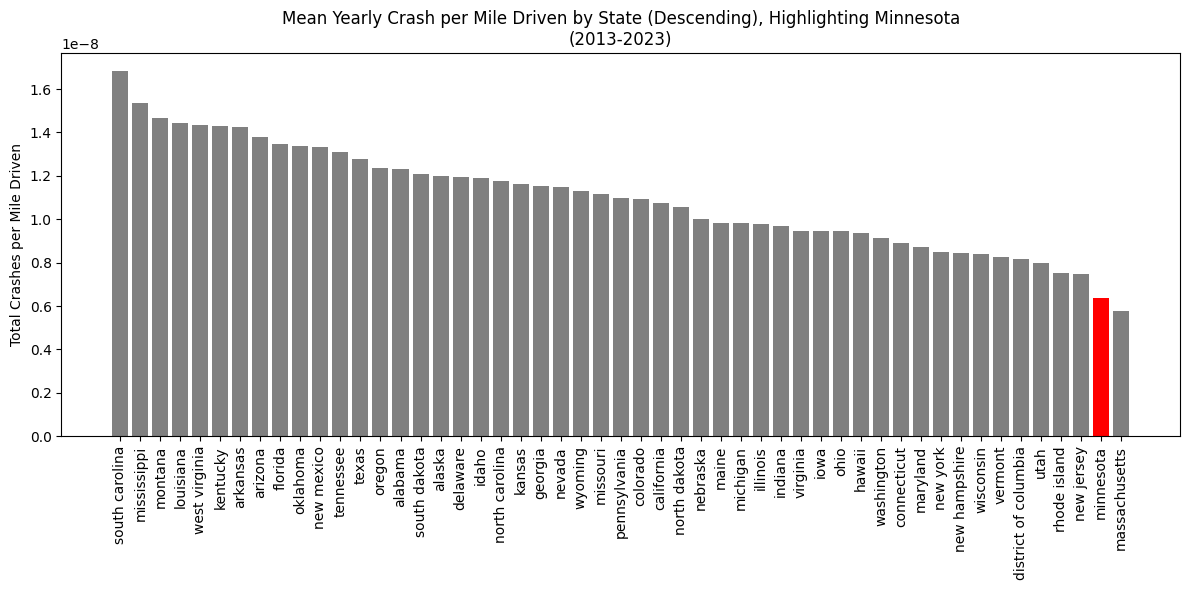

In [77]:
# Mean fatal interstate junction crashes per mile driven per year 2013-2023
crashes_per_mile_by_state = total_fatal_crash_per_mile.groupby("State")["crash_per_mile"].mean().reset_index().sort_values('crash_per_mile', ascending=False).reset_index(drop=True)

colors = ['red' if state == 'minnesota' else 'gray' for state in crashes_per_mile_by_state['State']]

plt.figure(figsize=(12,6))
plt.bar(crashes_per_mile_by_state['State'], crashes_per_mile_by_state['crash_per_mile'], color=colors)
plt.xticks(rotation=90)
plt.ylabel("Total Crashes per Mile Driven")
plt.title("Mean Yearly Crash per Mile Driven by State (Descending), Highlighting Minnesota\n(2013-2023)")
plt.tight_layout()
plt.show()

The p-value is 0.0428


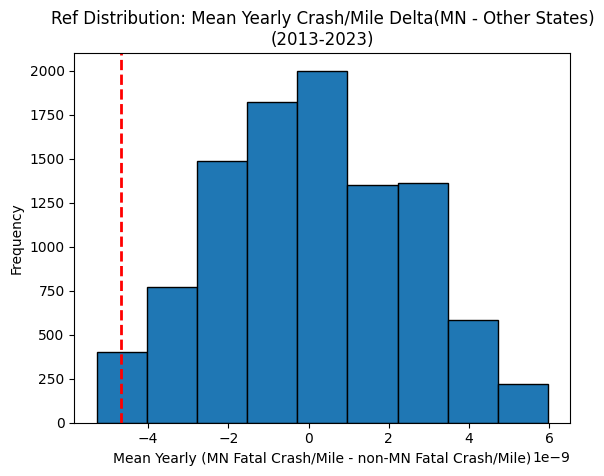

In [78]:
# Permutation Test - Does being in Minnesota have an effect on the number of crashes per mile driven?
# only at state level
crashes_per_mile_by_state['MN'] = np.where(crashes_per_mile_by_state['State'] == 'minnesota', 'MN', 'Not MN')
observed_diff = crashes_per_mile_by_state.groupby('MN')['crash_per_mile'].mean().loc['MN'] - crashes_per_mile_by_state.groupby('MN')['crash_per_mile'].mean().loc['Not MN']
# observed_diff, crashes_per_mile_per_year.groupby('MN')['Value'].mean().loc['MN'], crashes_per_mile_per_year.groupby('MN')['Value'].mean().loc['Not MN']

fatal_crash_state_mile = crashes_per_mile_by_state.copy()
fatal_crash_state_mile = fatal_crash_state_mile.reset_index(drop=True)

results =[]
n = 10_000

for i in range(n):
    fatal_crash_state_mile['MN'] = fatal_crash_state_mile['MN'].sample(frac=1,replace=False).values
    means = fatal_crash_state_mile.groupby('MN')['crash_per_mile'].mean()
    diff = means.loc["MN"] - means.loc["Not MN"]
    results.append(diff)

pval = 0

for i in range(0,n):
    if np.abs(results[i]) > np.abs(observed_diff):
        pval += 1
    else:
        pval += 0

pval = pval/n

print(f"The p-value is {pval}")

plt.figure()
plt.hist(results, bins = 9, edgecolor ='black')
plt.title("Ref Distribution: Mean Yearly Crash/Mile Delta(MN - Other States)\n(2013-2023)")
plt.ylabel("Frequency")
plt.xlabel("Mean Yearly (MN Fatal Crash/Mile - non-MN Fatal Crash/Mile)")
plt.axvline(x=observed_diff, color='red', linestyle='--', linewidth=2)
plt.show()


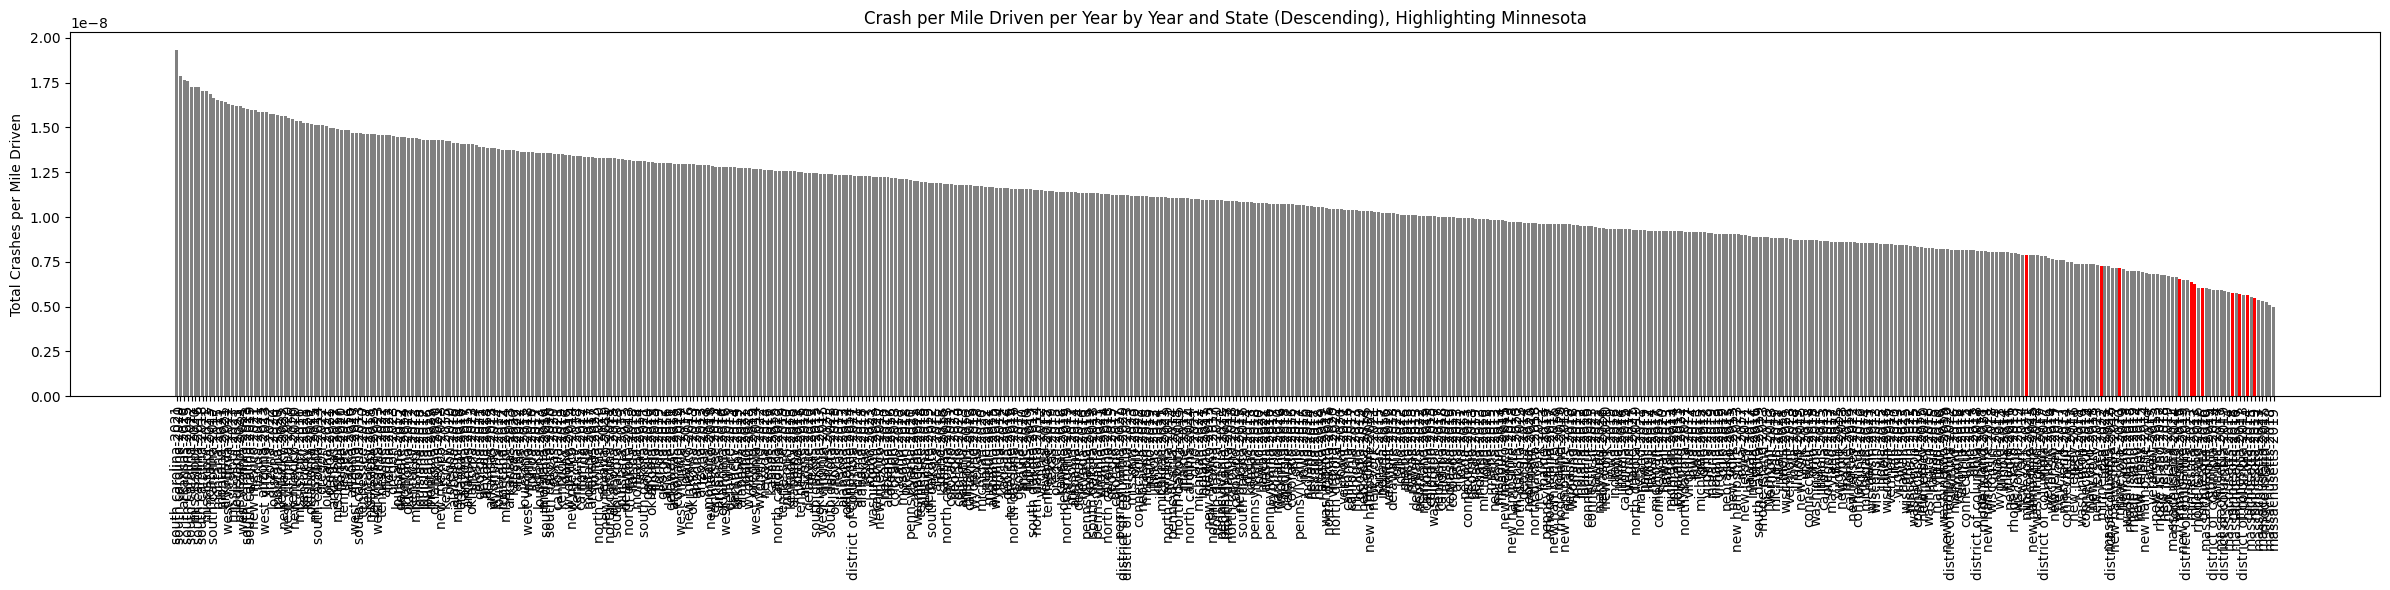

In [79]:
# Mean fatal interstate junction crashes per mile driven by year 2013-2023
crashes_per_mile_by_state_and_year = total_fatal_crash_per_mile[['State','Year','crash_per_mile']].sort_values('crash_per_mile', ascending=False).reset_index(drop=True).copy()
crashes_per_mile_by_state_and_year['State_Year'] = crashes_per_mile_by_state_and_year['State'] + "-" + crashes_per_mile_by_state_and_year['Year'].astype(str)
colors = ['red' if state == 'minnesota' else 'gray' for state in crashes_per_mile_by_state_and_year['State']]

plt.figure(figsize=(24,6))
plt.bar(crashes_per_mile_by_state_and_year['State_Year'], crashes_per_mile_by_state_and_year['crash_per_mile'], color=colors)
plt.xticks(rotation=90)
plt.ylabel("Total Crashes per Mile Driven")
plt.title("Crash per Mile Driven per Year by Year and State (Descending), Highlighting Minnesota")
plt.tight_layout()
plt.show()

# **This chart is not useful, lets show a confidence interval**

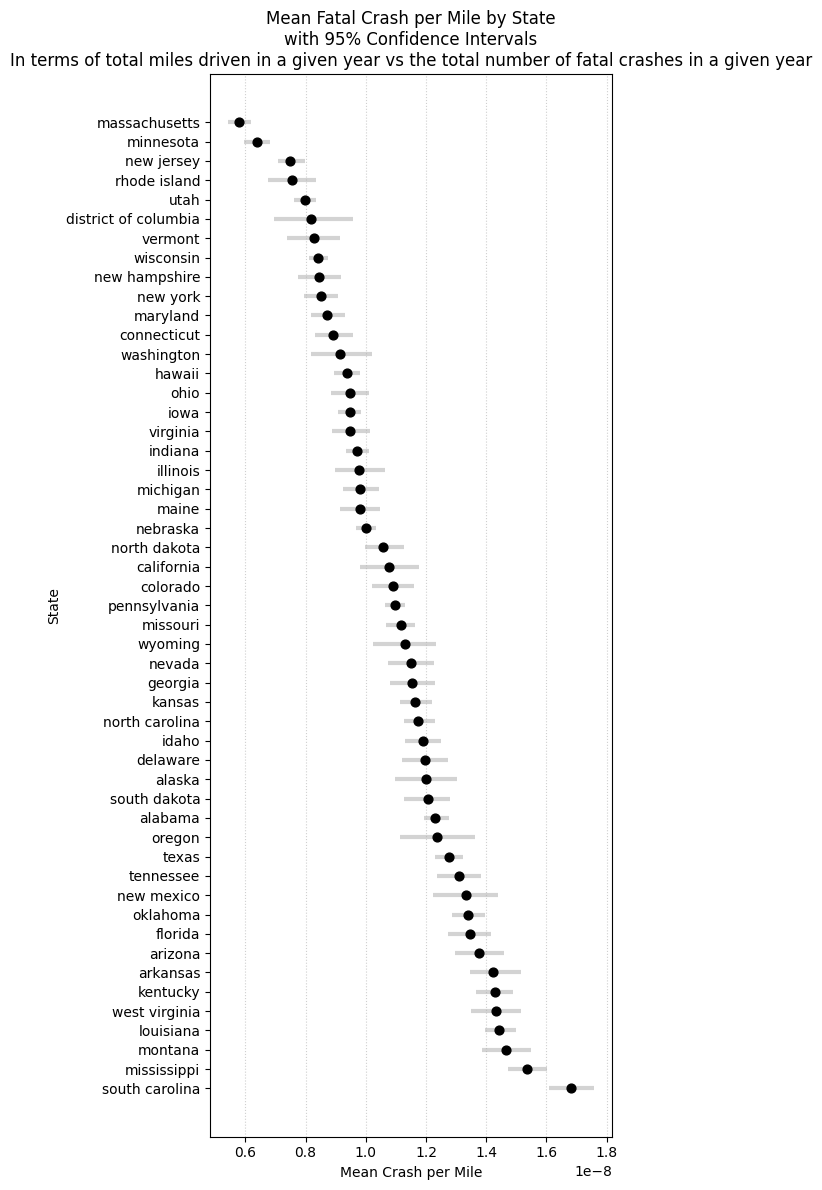

In [80]:
state_year_summary = crashes_per_mile_by_state_and_year.groupby('State')['crash_per_mile'].agg({'mean','count','std'}).reset_index()
state_year_summary['boot_se'] = pd.NA
state_year_summary['lower'] = pd.NA
state_year_summary['upper'] = pd.NA
n_sim = 5000

boot_means = {}

for idx, row in state_year_summary.iterrows():
    this_region = row['State']
    this_measures = crashes_per_mile_by_state_and_year.query(f"State =='{this_region}'")

    samples = []
    for _ in range(n_sim):
        this_sample = this_measures.sample(n=len(this_measures),replace = True)
        samples.append(np.mean(this_sample['crash_per_mile']))

    boot_means[this_region] = samples
    
    state_year_summary.loc[state_year_summary['State']==this_region,'boot_se'] = np.std(samples)
    state_year_summary.loc[state_year_summary['State']==this_region,'lower'] = np.quantile(samples,0.025)
    state_year_summary.loc[state_year_summary['State']==this_region,'upper'] = np.quantile(samples,0.975)
plt.figure(figsize=(6,12))

state_year_summary = state_year_summary.sort_values('mean', ascending=False).reset_index(drop=True)

# CI lines
plt.hlines(
    y=state_year_summary['State'],
    xmin=state_year_summary['lower'],
    xmax=state_year_summary['upper'],
    color='lightgray',
    lw=3,
    zorder=1
)

# Point estimates
plt.scatter(
    state_year_summary['mean'],
    state_year_summary['State'],
    s=40,
    color='black',
    zorder=2
)
plt.xlabel('Mean Crash per Mile')
plt.ylabel('State')
plt.title('Mean Fatal Crash per Mile by State\nwith 95% Confidence Intervals\nIn terms of total miles driven in a given year vs the total number of fatal crashes in a given year')
#plt.xlim(4, 5)
plt.grid(axis='x', linestyle=':', alpha=0.6, zorder=0)
plt.tight_layout()
plt.show()

### Note that this is not CLT compliant, as n=11 for each state, it is not sufficiently large.

In [81]:
pd.set_option("display.precision", 10)
state_year_summary[state_year_summary['State']=="minnesota"]

,State,mean,std,count,boot_se,lower,upper
49,minnesota,0.0000000064,0.0000000008,11,0.0000000002,0.000000006,0.0000000068


The p-value is 0.0


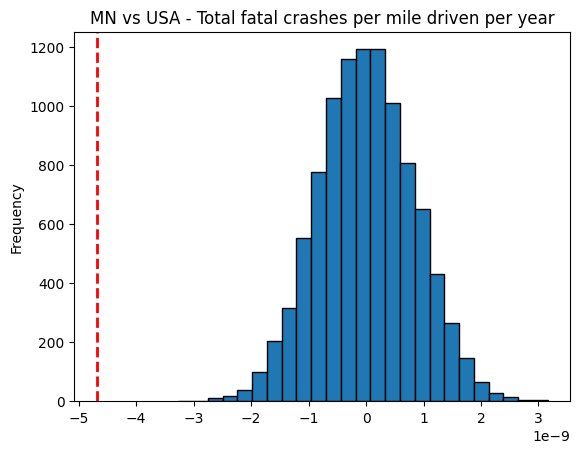

In [82]:
# Permutation Test - Does being in Minnesota have an effect on the number of crashes per mile driven?
# state and year level

crashes_per_mile_by_state_and_year['MN'] = np.where(crashes_per_mile_by_state_and_year['State'] == 'minnesota', 'MN', 'Not MN')
observed_diff = crashes_per_mile_by_state_and_year.groupby('MN')['crash_per_mile'].mean().loc['MN'] - crashes_per_mile_by_state_and_year.groupby('MN')['crash_per_mile'].mean().loc['Not MN']

fatal_crash_state_year_mile = crashes_per_mile_by_state_and_year.copy()
fatal_crash_state_year_mile = fatal_crash_state_year_mile.reset_index(drop=True)

results =[]
n = 10_000

for i in range(n):
    fatal_crash_state_year_mile['MN'] = fatal_crash_state_year_mile['MN'].sample(frac=1,replace=False).values
    means = fatal_crash_state_year_mile.groupby('MN')['crash_per_mile'].mean()
    diff = means.loc["MN"] - means.loc["Not MN"]
    results.append(diff)

pval = 0

for i in range(0,n):
    if np.abs(results[i]) > np.abs(observed_diff):
        pval += 1
    else:
        pval += 0

pval = pval/n

print(f"The p-value is {pval}")

plt.figure()
plt.hist(results, bins = 25, edgecolor ='black')
plt.title("MN vs USA - Total fatal crashes per mile driven per year")
plt.ylabel("Frequency")
plt.axvline(x=observed_diff, color='red', linestyle='--', linewidth=2)
plt.show()

In [83]:
# Calculate a CLT metric for bootstrapping.
# Metric: Total Fatal Crashes / Mile Driven across all State-Year data points. 
crashes_per_mile_by_state_and_year['State'] = "USA"

state_year_summary = crashes_per_mile_by_state_and_year.groupby('State')['crash_per_mile'].agg({'mean','count','std'}).reset_index()
state_year_summary['boot_se'] = pd.NA
state_year_summary['lower'] = pd.NA
state_year_summary['upper'] = pd.NA
n_sim = 5000

boot_means = {}

for idx, row in state_year_summary.iterrows():
    this_region = row['State']
    this_measures = crashes_per_mile_by_state_and_year.query(f"State =='{this_region}'")

    samples = []
    for _ in range(n_sim):
        this_sample = this_measures.sample(n=len(this_measures),replace = True)
        samples.append(np.mean(this_sample['crash_per_mile']))

    boot_means[this_region] = samples
    
    state_year_summary.loc[state_year_summary['State']==this_region,'boot_se'] = np.std(samples)
    state_year_summary.loc[state_year_summary['State']==this_region,'lower'] = np.quantile(samples,0.025)
    state_year_summary.loc[state_year_summary['State']==this_region,'upper'] = np.quantile(samples,0.975)

state_year_summary = state_year_summary.sort_values('mean', ascending=False).reset_index(drop=True)


In [84]:

state_year_summary

,State,mean,std,count,boot_se,lower,upper
0,USA,0.000000011,0.0000000027,561,0.0000000001,0.0000000107,0.0000000112


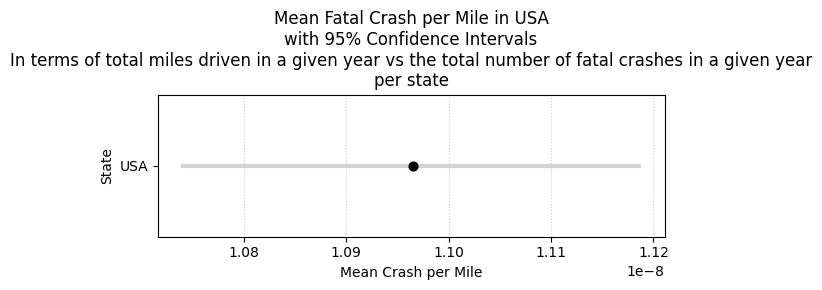

In [85]:
plt.figure(figsize=(6,3))
# CI lines
plt.hlines(
    y=state_year_summary['State'],
    xmin=state_year_summary['lower'],
    xmax=state_year_summary['upper'],
    color='lightgray',
    lw=3,
    zorder=1
)

# Point estimates
plt.scatter(
    state_year_summary['mean'],
    state_year_summary['State'],
    s=40,
    color='black',
    zorder=2
)
plt.xlabel('Mean Crash per Mile')
plt.ylabel('State')
plt.title('Mean Fatal Crash per Mile in USA\nwith 95% Confidence Intervals\nIn terms of total miles driven in a given year vs the total number of fatal crashes in a given year\nper state')
#plt.xlim(4, 5)
plt.grid(axis='x', linestyle=':', alpha=0.6, zorder=0)
plt.tight_layout()
plt.show()

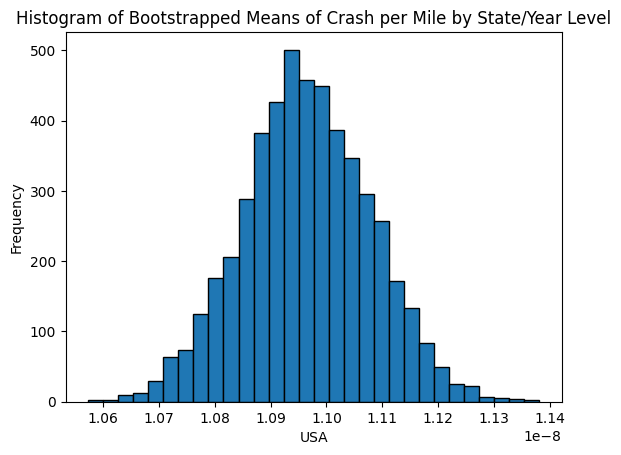

In [86]:
key = list(boot_means.keys())[0]

# get the list of values
values = boot_means[key]

plt.hist(values, bins=30, edgecolor='black')
plt.xlabel(key)
plt.ylabel("Frequency")
plt.title(f"Histogram of Bootstrapped Means of Crash per Mile by State/Year Level")
plt.show() 

# Final Results

**Test 1:** Interstate Junctions Fatal Crashes​
I could not find significant evidence to suggest merging on the interstate in MN is any more deadly than other states in the US.​
A major gap is the lack of non-fatal accidents. I can't make any statement around the likelihood of receiving a fender-bender while merging onto the interstate in MN vs other states. Perhaps interstate junction crashes are less likely to be fatal in general.​

**Test 2:** Total Fatal Crashes​
There is evidence based on this analysis to suggest that in MN you are less likely to be involved in a fatal motor vehicle accident per mile traveled. 


**Uncertainty**
Reviewed State level Crash/Mile uncertainty. This was not CLT Compliant as it violated the requirement of sufficently large samples. There were only 11 samples for each state.

Reviewed Country-wide Crash/Mile uncertainty. This was CLT compliant, as it grouped all state/year crash/mile data. This had over 500 samples. 

**Permutation test**
Permutation tests were ran and identified that MN did not stand out fatal crashes at interstate junctions vs the rest of the country, but they did stand out in total fatal crashes per mile regardless of the roadway. 

**Overall**
This analysis suggest MN might be a safer state to drive in, or at least has a lower risk of fatal injury per mile traveled in a motor vehicle. 
